In [1]:
import numpy as np
import pandas as pd

from os import path
import pickle

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel, f_classif, f_regression

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Import Data

Import the cleaned dataset produced in the data cleaning notebook:

In [10]:
f = 'loan_clean.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    data = pickle.load(file)

In [3]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,had_delinq,had_major_derog,had_record,annual_inc_merged,dti_merged,verification_status_merged
id,,,,,,,,,,,,,,,,,,,,,
10139658,12000.0,12000.0,12000.0,36 months,13.53,407.40,B,B5,10+ years,RENT,...,0.0,15386.0,13605.0,8100.0,1,1,1,40000.0,16.94,Source Verified
10179520,3000.0,3000.0,3000.0,36 months,12.85,100.87,B,B4,10+ years,RENT,...,0.0,154.0,19530.0,5300.0,1,1,1,25000.0,24.68,Verified
10149577,28000.0,28000.0,28000.0,36 months,7.62,872.52,A,A3,5 years,MORTGAGE,...,0.0,0.0,799592.0,54200.0,0,0,0,325000.0,18.55,Source Verified
10127816,24000.0,24000.0,24000.0,36 months,13.53,814.80,B,B5,10+ years,MORTGAGE,...,0.0,539.0,199834.0,28200.0,0,0,0,100000.0,22.18,Verified
10149566,8000.0,8000.0,8000.0,36 months,10.99,261.88,B,B2,2 years,MORTGAGE,...,0.0,0.0,15949.0,20800.0,0,0,1,33000.0,15.75,Not Verified


In [4]:
data.shape

(204056, 51)

In [5]:
data.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_py

### Data Preparation - Target Variables

##### Default Loans

For the purpose of classifying which loans of defaulted, the loan_status column will need to be converted into a binary status column.

In [11]:
data['loan_status'].value_counts()

Fully Paid            153872
Charged Off            35202
Late (31-120 days)     11457
Late (16-30 days)       2326
Default                 1199
Name: loan_status, dtype: int64

A very small proprotion of loans marked simply Default. Descriptions provided by LC imply that loans marked as both Default and Charged Off can to be treated as default, since charged off loans are simply a more severe case of defaulting. Additionally, any loans with a status of "Does not meet the credit policy..." will be simplified to their respective status.

In [7]:
def default_status(loan_status, harsh=False):
    
    if harsh:
        # Harsher classification of default loans which assumes all late loans will default
        s = re.compile('Charged|Default|Late')
    else:
        s = re.compile('Charged|Default')
    
    if re.search(s, loan_status):
        default = 1
    else:
        default = 0
        
    return default

In [8]:
# Regular defintion of default loans
data['default'] = data['loan_status'].apply(default_status)

# Harsher definition of default loans (late = default)
data['default_harsh'] = data['loan_status'].apply(lambda x: default_status(x, harsh=True))

In [9]:
data['default'].value_counts()

0    167655
1     36401
Name: default, dtype: int64

In [10]:
data['default_harsh'].value_counts()

0    153872
1     50184
Name: default_harsh, dtype: int64

##### Default vs. Default Harsh

Before moving on, it is important to determine which definition of default loans we will use, since the harsh definition requires the inclusion of late loan status records which need to be removed otherwise.

In [11]:
late_loan_mask = data['loan_status'].str.contains('Late')
default_mask = (data['default'] == 1) & ~late_loan_mask
default_harsh_mask = data['default_harsh'] == 1

In [12]:
# Percent default loans w/ regular definition (late loans removed)
default_mask.sum() / data[~late_loan_mask].shape[0]

0.19130932922695285

In [13]:
# Percent defualt loans w/ harsh definiton
default_harsh_mask.sum() / data.shape[0]

0.24593248912063356

The harsh definitions gives us a boost of approx. 5% in terms of proportion of total data used, so it is possible this alternate approach could improve modelling by giving more natural weight to our class of interest. Using Logistic Regression as a benchmark for comparison, we will see if there are any immediate advantages to using one approach over the other. Since we are dealing with a binary classification problem, we will be using f1 and recall scoring to measure and compare model accuracy.

First, some basic setup for modeling:

In [14]:
# Default set of columns without any feature selection
num_attr = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_vals']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record']

cat_attr = ['emp_length', 'purpose', 'home_ownership', 'verification_status', 'application_type', 'term']

In [40]:
# Class for selecting attributes from a dataframe, for use in pipelines

class DataFrame_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names

In [41]:
# Converts categorical features into OHE features using pandas get_dummies.
# Can take a list of valid dummy column names to ensure consistency between data sets with different categorical values.
class DataFrame_DummyEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names, valid_dummy_cols=None):
        self.attribute_names = attribute_names
        # In case categorical values differ between datasets
        self.valid_dummy_cols = valid_dummy_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.valid_dummy_cols is not None:
            zero_data = np.zeros(shape=(len(X),len(self.valid_dummy_cols)))
            self.dummies = pd.DataFrame(zero_data, columns=valid_dummy_cols)
            d = pd.get_dummies(X[self.attribute_names])

            for col in d.columns:
                if col in self.dummies.columns:
                    self.dummies[col] = d[col].values
        else:
            self.dummies = pd.get_dummies(X[self.attribute_names])
        return self.dummies.values
    
    def get_feature_names(self):
        return self.dummies.columns.tolist()

In [17]:
# Maps custom numerical features
class CustomNumAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.feature_names = []
        
        # Note: following assumes that X is still be a pandas DataFrame vs. numpy array. 
        grade_map = {grade: i for i, grade in enumerate('ABCDEFG')}
        X['grade_vals'] = X['grade'].map(grade_map)
        self.feature_names.append('grade_vals')
        
        # Note: following assumes that X is still be a pandas DataFrame vs. numpy array. 
        subgrade_map = {sg: grade_map[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}
        X['subgrade_vals'] = X['sub_grade'].map(subgrade_map)
        self.feature_names.append('subgrade_vals')
        
        return X
    def get_feature_names(self):
        return X.columns.tolist()

In [18]:
# Get set of valid dummy columns names for OHE to ensure consistency between train/test sets
valid_dummy_cols = pd.get_dummies(data[cat_attr]).columns

In [19]:
num_prep = Pipeline([('custom', CustomNumAttributes()), # Create custom features (grade & subgrade)
                     ('select', DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('select', DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', DataFrame_DummyEncoder(cat_attr, valid_dummy_cols))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

Note the above steps include some basic grade and subgrade value mapping to convert grades into numerical equivalents. This will be discussed in greater detail later, but is already included for these models due to the high correlatin of these features with default status.

Version 1 using regular 'default' only:

In [20]:
# Select only regular default records
X = feature_prep.fit_transform(data[~late_loan_mask].copy())
y = data[~late_loan_mask]['default']

In [21]:
# CV f1 score for Logistic Regression
linreg_f1_v1 = cross_val_score(estimator = LogisticRegression(),
                                X = X,
                                y = y,
                                scoring='f1',
                                cv = 5,
                                n_jobs=4)

In [22]:
# CV recall score for Logistic Regression
linreg_recall_v1 = cross_val_score(estimator = LogisticRegression(),
                                X = X,
                                y = y,
                                scoring='recall',
                                cv = 5,
                                n_jobs=4)

In [23]:
print('CV f1 score = {:.3f} (+/- {:.3f})'.format(linreg_f1_v1.mean(), linreg_f1_v1.std()))
print('CV recall score = {:.3f} (+/- {:.3f})'.format(linreg_recall_v1.mean(), linreg_recall_v1.std()))

CV f1 score = 0.585 (+/- 0.089)
CV recall score = 0.420 (+/- 0.089)


Version 2 using harsh default definition:

In [24]:
# Select all records, including late loans
X = feature_prep.fit_transform(data.copy())
y = data['default_harsh']

In [25]:
# CV f1 score for Logistic Regression
linreg_f1_v2 = cross_val_score(estimator = LogisticRegression(),
                                X = X,
                                y = y,
                                scoring='f1',
                                cv = 5,
                                n_jobs=4)

In [26]:
# CV recall score for Logistic Regression
linreg_recall_v2 = cross_val_score(estimator = LogisticRegression(),
                                X = X,
                                y = y,
                                scoring='recall',
                                cv = 5,
                                n_jobs=4)

In [27]:
print('CV f1 score = {:.3f} (+/- {:.3f})'.format(linreg_f1_v2.mean(), linreg_f1_v2.std()))
print('CV recall score = {:.3f} (+/- {:.3f})'.format(linreg_recall_v2.mean(), linreg_recall_v2.std()))

CV f1 score = 0.477 (+/- 0.154)
CV recall score = 0.337 (+/- 0.133)


Although this is a rather basic comparison, the default_harsh approach performs signficantly worse than our traditional default definition in both f1 and recall scores. We could explore this further with proper train/test splits, parameter tunings, etc., but given the comprimise to the definition of default status involved with the alternative approach it is likely best to stick with the true definition of default loans.

We will remove the late records from our data along with the now deprecated 'default_harsh' column:

In [28]:
# Extract late loans
data_late = data[late_loan_mask]

# Save late loan data in separate file
f = 'loan_late.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'wb') as file:
    pickle.dump(data_late, file)

In [29]:
# Remove late status entries
data = data[~late_loan_mask].copy()

In [30]:
data['loan_status'].value_counts()

Fully Paid     153872
Charged Off     35202
Default          1199
Name: loan_status, dtype: int64

In [31]:
data['default'].value_counts()

0    153872
1     36401
Name: default, dtype: int64

In [32]:
# Drop alternative default status column used for including late status loans as default
data.drop('default_harsh', axis=1, inplace=True)

##### Loan Return

As established during EDA, the percentage return on a loan is not only the most balanced metric for comparing loans of different magnitude, but also the more meaningful measurement for the business context.

In [33]:
def loan_p_return(loan):
    return (loan['total_pymnt'] - loan['funded_amnt']) / loan['funded_amnt']

In [34]:
data['loan_p_return'] = data[['total_pymnt', 'funded_amnt']].apply(loan_p_return, axis=1)

### Feature Engineering

##### Grade Values

As mentioned earlier, grade values should be converted into a numerical scale. Although a categorical feature, since higher grades signify higher value. this should translate with little issue.

The most straightforward approach is to give incremeting values to each grade. For grades A through G we simply assign values of 0-6:

In [35]:
grade_map = {c: i for i, c in enumerate('ABCDEFG')}

data['grade_value'] = data['grade'].map(grade_map)

Subgrade is a little more difficult, since we need to quantify the 1-5 subgrade range for each letter grade value (e.g. A1, A2, etc.). If we take our previous 0-7 letter value assignment as the tens place for our scores, we can increment by the 1 through 5 values. For example, A1-A5 translates to 1-5, and G1-G5 to 61-65:

In [36]:
subgrade_map = {sg: grade_map[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}

data['subgrade_value'] = data['sub_grade'].map(subgrade_map)

These score conversion are obviously fairly simplistic and assume a linear progression in value from one score to the next. An alternative approach would be to weigh scores according to their proportion of defaulted loans:

In [37]:
data.groupby('grade')['default'].mean()

grade
A    0.060720
B    0.125616
C    0.201092
D    0.271114
E    0.338269
F    0.390544
G    0.420849
Name: default, dtype: float64

In [38]:
grade_p_map = data.groupby('grade')['default'].mean()

data['grade_p_value'] = data['grade'].map(grade_p_map)

In [39]:
data.groupby('sub_grade')['default'].mean()

sub_grade
A1    0.029523
A2    0.041678
A3    0.049311
A4    0.071349
A5    0.081799
B1    0.100133
B2    0.107047
B3    0.126975
B4    0.138717
B5    0.150429
C1    0.167228
C2    0.182722
C3    0.206470
C4    0.220445
C5    0.235816
D1    0.251399
D2    0.263850
D3    0.261624
D4    0.294196
D5    0.299425
E1    0.299946
E2    0.337000
E3    0.346965
E4    0.351322
E5    0.375163
F1    0.347039
F2    0.373061
F3    0.417305
F4    0.418933
F5    0.441542
G1    0.429603
G2    0.408629
G3    0.434629
G4    0.347059
G5    0.477124
Name: default, dtype: float64

In [40]:
subgrade_p_map = data.groupby('sub_grade')['default'].mean()

data['subgrade_p_value'] = data['sub_grade'].map(subgrade_p_map)

In [41]:
data[['grade', 'sub_grade', 'grade_p_value', 'subgrade_p_value']].head(10)

,grade,sub_grade,grade_p_value,subgrade_p_value
id,,,,
10139658,B,B5,0.125616,0.150429
10179520,B,B4,0.125616,0.138717
10149577,A,A3,0.060720,0.049311
10127816,B,B5,0.125616,0.150429
10148818,C,C2,0.201092,0.182722
10149488,B,B2,0.125616,0.107047
10129506,B,B5,0.125616,0.150429
10079457,B,B3,0.125616,0.126975
10089642,B,B2,0.125616,0.107047


##### Simplified Application Type

There are only two types of applications: JOINT and INDIVIDUAL. Consequently this information can be simplified into a single binary value to indicate if it is joint or not

In [42]:
data['application_type'].value_counts()

INDIVIDUAL    190272
JOINT              1
Name: application_type, dtype: int64

Turns out that during our data cleaning process we have actually lost all but 1 of the JOINT type records. We will drop this column and all of our 'merged' column which sought to combine values from joint applications with the regular values:

In [43]:
data.drop(['application_type', 'dti_merged', 'annual_inc_merged', 'verification_status_merged'], axis=1, inplace=True)

Moving forward we should revert to using the original annual_income and dti columns.

##### Simplified Verification Status

Verification status is currently split into 3 values:

In [44]:
data['verification_status'].value_counts()

Verified           72663
Not Verified       59787
Source Verified    57823
Name: verification_status, dtype: int64

Distinguishing between verified and source verified serves little purpose, so for the sake of simplicity it would be better to reduce it to a binary feature:

In [45]:
data['verified'] = (data['verification_status'] != 'Not Verified').astype(int)

##### Simplified Home Ownership

Home ownership has a few small categories:

In [131]:
data['home_ownership'].value_counts()

MORTGAGE    97383
RENT        75705
OWN         17102
OTHER          42
NONE           40
ANY             1
Name: home_ownership, dtype: int64

The category 'ANY' should be merged into a singular 'OTHER':

In [133]:
data['home_ownership'] = data['home_ownership'].apply(lambda x: x if x != 'ANY' else 'OTHER')

In [134]:
data['home_ownership'].value_counts()

MORTGAGE    97383
RENT        75705
OWN         17102
OTHER          43
NONE           40
Name: home_ownership, dtype: int64

##### Annual Income Ratios

One potentially useful measure which has yet to be captured is how the loan and installment amounts compare to the annual income. During EDA it was established that there seems to be some correlation between larger ratios of loan amounts, balances, etc. to income and default rates, so perhaps these will prove useful for modeling.

In [46]:
# LTI = Loan to Income (akin to DTI)
data['lti'] = data['funded_amnt'] / data['annual_inc']

Along similar lines, the magnitude of the monthly payment amount relative to annual income may also be of use:

In [47]:
# ITI = installment to income
data['iti'] = data['installment'] / data['annual_inc']

Comparing the balances to income:

In [48]:
# RBTI = revol balance to income
data['rbti'] = data['revol_bal'] / data['annual_inc']

In [49]:
# TBTI = total balance to income
data['tbti'] = data['tot_cur_bal'] / data['annual_inc']

##### Relative Interest Rates

During EDA it was found that interest rates were generally constant for a given loan subgrade and issue date (month & year). The variation of interest rates over time may correlate with the overall economic cirumstances at the times, and subsequently may prove of use for capturing some of the risk expected for a loan.

In [50]:
subgrade_int_rate_mean = data.groupby('sub_grade')['int_rate'].mean()
subgrade_int_rate_std = data.groupby('sub_grade')['int_rate'].std()

In [51]:
# Number of standard deviations from the mean for a given subgrade
data['int_rate_delta'] = data[['int_rate','sub_grade']].apply(lambda x: (x['int_rate'] - subgrade_int_rate_mean[x['sub_grade']]) / subgrade_int_rate_std[x['sub_grade']], axis=1)

In [52]:
data['int_rate_delta'].head()

id
10139658    0.505176
10179520    0.505656
10149577    0.631236
10127816    0.505176
10148818    0.273110
Name: int_rate_delta, dtype: float64

This approach may, however, unfairly punish older loans due to what seems to be a decreasing of interest rates over the years. A better alternative may be to take a more granular approach comparing loans in a given year with the means of said year. The problem with this, however, is that in predicting future loans issued past 2016, supplemental interest rate means and standrard deviations would need to be provided, which may not be feasible. Consequently, feature selection will simply have to do in terms of deciding if this new but simplistic calculation is of use or not.

##### Earliest Credit Date

Earliest credit date is one of the few date we can use for analysis due it being a static timestamp (versus things like last payment date). However, in its default datetime format it is not of much use for modeling. We can, however, convert this datetime into a relative time delta from the issue date to capture the age of a persons credit history relative to when the loan was requested.

In [53]:
# Day difference between credit history start and issue date
data['earliest_cr_line_td'] = [(issue_d.date() - cr.date()).days for issue_d, cr in zip(data['issue_d'], data['earliest_cr_line'])]

In [54]:
data[['issue_d', 'earliest_cr_line','earliest_cr_line_td']].head(10)

,issue_d,earliest_cr_line,earliest_cr_line_td
id,,,
10139658,2013-12-01,1998-10-01,5540
10179520,2013-12-01,1991-05-01,8250
10149577,2013-12-01,1994-11-01,6970
10127816,2013-12-01,1989-01-01,9100
10148818,2013-12-01,1992-07-01,7823
10149488,2013-12-01,1995-08-01,6697
10129506,2013-12-01,1998-06-01,5662
10079457,2013-12-01,2001-07-01,4536
10089642,2013-12-01,1978-11-01,12814


In [55]:
data[data['earliest_cr_line_td'] <= 0]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,subgrade_value,grade_p_value,subgrade_p_value,verified,lti,iti,rbti,tbti,int_rate_delta,earliest_cr_line_td
id,,,,,,,,,,,,,,,,,,,,,


As one would hope, there are no instances with a credit history which starts past the time of a loan being issued. As for the distribution of our new feature:

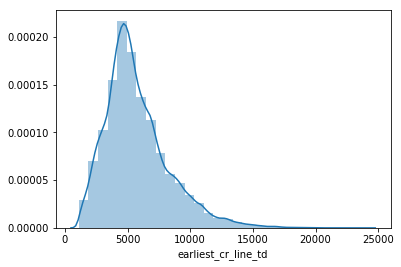

In [56]:
sns.distplot(data['earliest_cr_line_td'], bins=30)
plt.show()

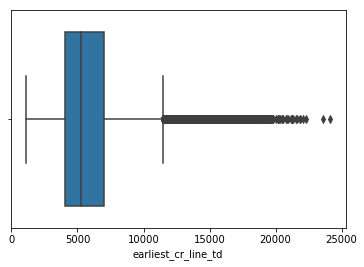

In [57]:
sns.boxplot(data['earliest_cr_line_td'])
plt.show()

At first glance a relatively clean distribution, albeit with a similar right skew & high outliers we have observed with many of our other feautures like income. Scaling these features to balance out the higher values may prove beneficial.

##### Scaling Features (log, sqrt)

Some features have a number of records with signficantly higher values which may yield undesirable results. This was already somewhat addressed during initial data cleaning with removing the most extreme values, but for the sake of preserving data there are still a considerable number of values outside the expected range (i.e. Tukey ranges [Q1 - 1.5\*IQR, Q3 + 1.5\*IQR]). Consequently, scaling such features via log or square root may prove beneficial by minimizng the impact of more extreme values which remain.

The main features to consider are those already addressed during data cleaning:
- Annual Income
- Revolving Balance & Utilization
- Total Balance and Total Collection
- Total Revolving Limit

We will create a log (zero values remain zero) and square root equivelent for each of these and let feature selection procedures determine the usefulness:

In [58]:
# Annual Income
data['annual_inc_log'] = data['annual_inc'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['annual_inc_sqrt'] = np.sqrt(data['annual_inc'])

In [59]:
# Revolving balance
data['revol_bal_log'] = data['revol_bal'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['revol_bal_sqrt'] = np.sqrt(data['revol_bal'])

In [60]:
# Revolving utilization
data['revol_util_log'] = data['revol_util'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['revol_util_sqrt'] = np.sqrt(data['revol_util'])

In [61]:
# Total balance
data['tot_bal_log'] = data['tot_cur_bal'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['tot_bal_sqrt'] = np.sqrt(data['tot_cur_bal'])

In [62]:
# Total Collections
data['tot_coll_log'] = data['tot_coll_amt'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['tot_coll_sqrt'] = np.sqrt(data['tot_coll_amt'])

In [63]:
# Total Rev Lim
data['rev_lim_log'] = data['total_rev_hi_lim'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['rev_lim_sqrt'] = np.sqrt(data['total_rev_hi_lim'])


Additionally, we just created the earliest credit date feature, which shows a similar distribution and consequently may also benefit from various scaling.

In [64]:
data['cr_line_td_log'] = data['earliest_cr_line_td'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['cr_line_td_sqrt'] = np.sqrt(data['earliest_cr_line_td'])

Finally, whilst loan amount does have hard cap at 35,000 it may still be worthwhile peforming this same process to help balance comparisons between loans at either end of the spectrum:

In [65]:
# Loan amount (using funded amount)
data['funded_amnt_log'] = data['funded_amnt'].apply(lambda x: np.log10(x) if x >= 1 else 0)
data['funded_amnt_sqrt'] = np.sqrt(data['funded_amnt'])

##### Quantile Features

Another approach to handling features with a large range of values is by splitting records into quantile bins. This was already explored in EDA, in which splitting into 10th percentile bins proved to show much smoother trends for things like income. We could technically repeat this binning for all the features addressed in the log/sqrt scaling above, but this would likely prove excessive since we already expect to have to eliminate a number of them for being redundant or of little importance.

Consequently, we will limit this quantile to what we deem the most significant features: income & loan amount.  

In [14]:
def get_qbin(val, quartiles):
    '''
    Return which of the provided quartiles the value falls in.
    '''
    for i, q in enumerate(quartiles):
        if val <= q:
            return i+1
    return len(quartiles) # If value exceeds last quartile, bin with last quartile

In [67]:
# Annual income, 10th percentiles
q = 0.1
q_range = np.arange(q, 1+q, q)
quantiles = data['annual_inc'].quantile(q_range)
data['annual_inc_q10'] = data['annual_inc'].apply(lambda x: get_qbin(x, quantiles))

In [68]:
# Funded amount, 10th percentiles
q = 0.1
q_range = np.arange(q, 1+q, q)
quantiles = data['funded_amnt'].quantile(q_range)
data['funded_amnt_q10'] = data['funded_amnt'].apply(lambda x: get_qbin(x, quantiles))

### Feature Selection

##### Evaluate duplicated features

We have created a number of new features which are simply different scalings and representations of the same value. For the purposes of modeling, only one of these should be used or else our results will be unfairly influenced by these duplicated indicators. We will select the best feature for each set using Select K Best and F-Test scoring:

In [69]:
def get_k_best(X, y, k=1, attribute_names=None, score_func=f_classif):
    attr = X.columns if attribute_names is None else attribute_names
    select_best = Pipeline([('df_select', DataFrame_Selector(attribute_names=attr)),
                            ('sc', StandardScaler()),
                            ('select_best', SelectKBest(k=k, score_func=score_func))])
    select_best.fit(X,y)
    scores = select_best.named_steps['select_best'].scores_
    return [attr[i] for i in np.argsort(scores)][::-1][:k]

In [70]:
feature_sets = [['annual_inc', 'annual_inc_log', 'annual_inc_sqrt', 'annual_inc_q10'],
                ['revol_bal', 'revol_bal_log', 'revol_bal_sqrt'],
                ['revol_util', 'revol_util_log', 'revol_util_sqrt'],
                ['tot_cur_bal', 'tot_bal_log', 'tot_bal_sqrt'],
                ['tot_coll_amt', 'tot_coll_log', 'tot_coll_sqrt'],
                ['total_rev_hi_lim', 'rev_lim_log', 'rev_lim_sqrt'],
                ['funded_amnt', 'funded_amnt_log', 'funded_amnt_sqrt', 'funded_amnt_q10'],
                ['earliest_cr_line_td', 'cr_line_td_log', 'cr_line_td_sqrt']]

In [71]:
# Summary for classification
best_c_features = []
for cols in feature_sets:
    best_c_features.append(get_k_best(data, data['default'], attribute_names=cols, k=1))
    print('Best {} feature: {}'.format(cols[0], best_c_features[-1]))

Best annual_inc feature: ['annual_inc_q10']
Best revol_bal feature: ['revol_bal_log']
Best revol_util feature: ['revol_util']
Best tot_cur_bal feature: ['tot_cur_bal']
Best tot_coll_amt feature: ['tot_coll_amt']
Best total_rev_hi_lim feature: ['rev_lim_sqrt']
Best funded_amnt feature: ['funded_amnt_q10']
Best earliest_cr_line_td feature: ['cr_line_td_log']


In [72]:
# Summary for regression
best_r_features = []
for cols in feature_sets:
    best_r_features.append(get_k_best(data, data['loan_p_return'], attribute_names=cols, k=1, score_func=f_regression))
    print('Best {} feature: {}'.format(cols[0], best_r_features[-1]))

Best annual_inc feature: ['annual_inc_q10']
Best revol_bal feature: ['revol_bal_log']
Best revol_util feature: ['revol_util']
Best tot_cur_bal feature: ['tot_cur_bal']
Best tot_coll_amt feature: ['tot_coll_log']
Best total_rev_hi_lim feature: ['rev_lim_log']
Best funded_amnt feature: ['funded_amnt_q10']
Best earliest_cr_line_td feature: ['cr_line_td_log']


Only distinction between our classification and regression problems are with tot_coll_amt and total_rev_hi_lim. Regardless, will drop the columns which did not score best in either (still keep original columns):

In [73]:
drop_cols = ['annual_inc_log', 'annual_inc_sqrt',
             'revol_bal_sqrt',
             'revol_util_log', 'revol_util_sqrt',
             'tot_bal_log', 'tot_bal_sqrt',
             'tot_coll_sqrt',
             'funded_amnt_log', 'funded_amnt_sqrt',
             'cr_line_td_sqrt']

In [74]:
data.drop(drop_cols, axis=1, inplace=True)

Similarly, the various values for grade and subgrade should also be explored:

In [75]:
# Best grade feature for classification
get_k_best(data, data['default'], attribute_names=['grade_value', 'subgrade_value', 'grade_p_value', 'subgrade_p_value'])

['subgrade_p_value']

In [76]:
# Best grade feature for regression
get_k_best(data, data['loan_p_return'], attribute_names=['grade_value', 'subgrade_value', 'grade_p_value', 'subgrade_p_value'], score_func=f_regression)

['subgrade_p_value']

The subgrade_p_value turns out to the strongest indicator or both the classification and regression problems.

Note that without further analysis, this approach does make a rather broad assumption that the best F-test scoring translates directly to all types of models. The alternative and more in-depth approach would be to evaluate the change in model performance with the use of each of these feature variations. However, this would be an extremely time consuming process given the number of feature variations and subsequent permutations possible.

##### Eliminating Highly Correlated Features

We have already addressed a number of correlated features above, but to ensure we have not missed anything concerning we will take a look at a correlation heatmap between our remaining columns.

In [122]:
# Ignore future / unused values, deprecated columns, and target variables
ignore_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee',
               'total_rec_int','recoveries', 'last_pymnt_amnt', 'loan_p_return', 'default', 'funded_amnt_inv', 'loan_amnt',
               'annual_inc', 'revol_bal', 'total_rev_hi_lim', 'funded_amnt', 'earliest_cr_line_td']

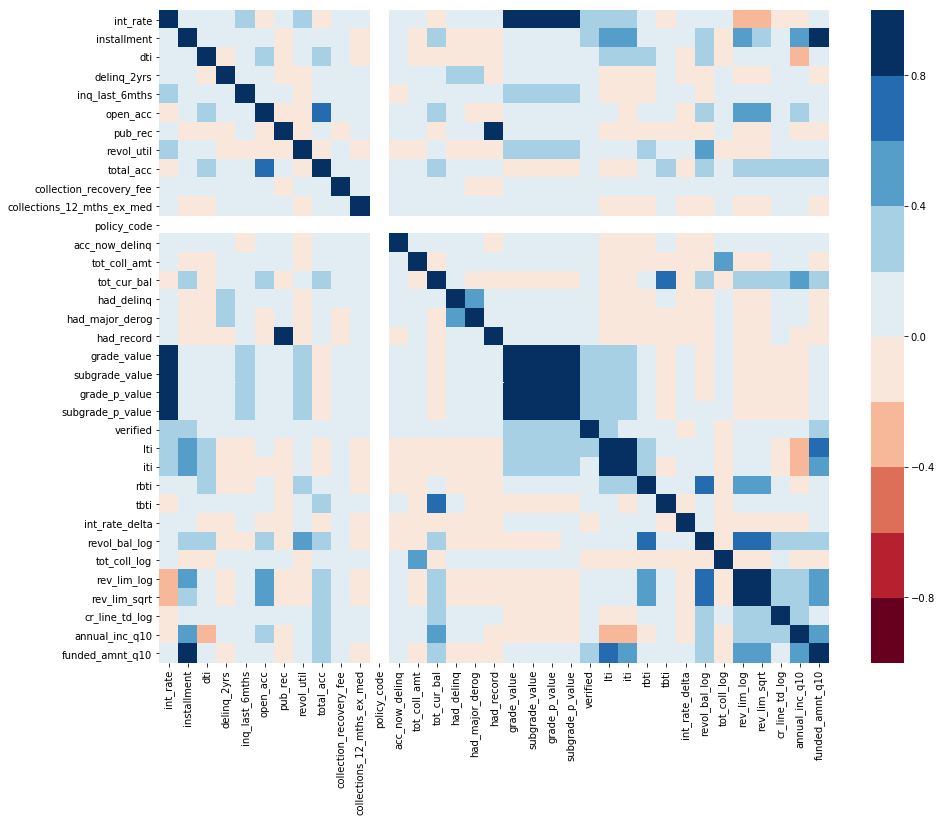

In [123]:
plt.figure(figsize=(15,12))
sns.heatmap(data.drop(ignore_cols, axis=1).corr(), cmap=plt.get_cmap('RdBu',10), vmin=-1, vmax=1)
plt.show()

The following notable observations can be made (focusing on correlations exceeding a magnitude of 0.9):

int_rate obviously has a high correlation with all variations of grade values. We had already indentified this connection during EDA and have consequently ignored it in favor of grades. The new int_rate_delta, however, should provide a reasonable substitute to at least gain some information from the interest rate attribute to supplement grade values.

pub_rec and had_record are highly correlated, as one might expect. Only one of these should be used in modeling:

In [105]:
cols = ['pub_rec', 'had_record']

In [106]:
# Classification
get_k_best(data, data['default'], attribute_names=cols, k=1)

['had_record']

In [107]:
# Regression
get_k_best(data, data['loan_p_return'], attribute_names=cols, k=1, score_func=f_regression)

['pub_rec']

Classification favors had_record, whereas regression favors pub_rec.

Finally, installment is highly correlated with funded_amnt_q10. The new feature 'iti' (installment to income ratio) would make a suitable replacement, but this is also highly correlated with 'lti' (loan to income). Dropping something as fundamental as the funded amount is out of the question, so one of the other 2 ratios should be selected:

In [124]:
cols = ['iti', 'lti']

In [127]:
# Classification
get_k_best(data, data['default'], attribute_names=cols, k=1)

['lti']

In [129]:
# Regression
get_k_best(data, data['loan_p_return'], attribute_names=cols, k=1, score_func=f_regression)

['lti']

Loan to income (LTI) is favorable for both classification and regression.

All other highly correlated items have been addressed, and those in 0.8 magnitude range are being left to be handled by individual model feature selection and regularization processes.

### PCA

We will explore the feasibility of PCA by exploring whether or not we can capture an acceptable amount of variance with a reduced set of dimensions/components.

In [78]:
# Using default column values vs. those indicated in select k best due to variations between best features in classification and regression
num_attr = ['funded_amnt', 'int_rate_delta', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value', 'earliest_cr_line_td',
            'lti', 'rbti', 'tbti']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified']

cat_attr = ['emp_length', 'purpose', 'home_ownership', 'term']

In [79]:
num_prep = Pipeline([('select', DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('select', DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', DataFrame_DummyEncoder(cat_attr, valid_dummy_cols))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [80]:
X = feature_prep.fit_transform(data)

In [81]:
X.shape

(190273, 66)

In [82]:
def plot_pca_var(X, p=0.9):

    pca = PCA()
    pca.fit(X)

    plt.figure(figsize=(10,5))

    n = len(pca.explained_variance_ratio_)
    exp_var = pca.explained_variance_ratio_
    exp_var_cumsum = np.cumsum(exp_var)

    x = next(i for i, n in enumerate(exp_var_cumsum) if n >= p) + 1

    plt.bar(np.arange(1, n+1, 1), exp_var, align='center', label='Explained Variance Ratio')
    plt.step(np.arange(1, n+1, 1), exp_var_cumsum, where='mid', label='Cumulative Explained Variance Ratio')
    
    plt.hlines(p, 0, n, label='{}% Explained Variance Ratio'.format(p*100), lw=1, color='r', linestyle='dashed')
    plt.plot([x, x], [0, p], linestyle='--',color='k', markeredgewidth=3, ms=8, lw=1)
    plt.plot([x], [p], marker='x', color='k', markeredgewidth=2, ms=8, lw=.5)
    plt.annotate(x, (x+.5, p-0.05))
    
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlim(0, n)
    plt.title('Principal Component Analysis')
        
    plt.show()
    return pca

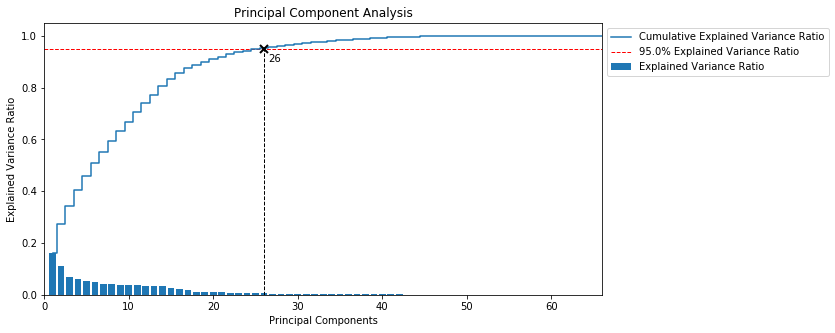

In [83]:
pca = plot_pca_var(X, 0.95)

In [84]:
l = len(pca.explained_variance_ratio_)
for p in [0.9, 0.95, 0.99, 0.999]:
    n = np.argmax(np.cumsum(pca.explained_variance_ratio_) > p) + 1
    print('{}% Variance Explained: {} components; {} ({:.0f}%) reduction'.format(p*100, n, l-n, 100*(l-n)/l ))

90.0% Variance Explained: 19 components; 47 (71%) reduction
95.0% Variance Explained: 26 components; 40 (61%) reduction
99.0% Variance Explained: 39 components; 27 (41%) reduction
99.9% Variance Explained: 48 components; 18 (27%) reduction


Even accounting for 99.9% of variance allows us to reduce dimensionality by 18 (27%). Not only may this prove useful for potential noise reduction, but models that may struggle with the size of the dataset and number of dimensions could also see vast improvements in computation times with potentially minimal impact to performance. Given these results, the impact of PCA should be explored in the context of each model.

### Summarizing Data Preparation

With the fundamentals of data cleaning and preperation complete, it would be wise to create functions to automate the various steps taken to get our raw dataset to its current state. This will allow quickly converting our raw data to a cleaned version, and any future changes/additions should be simple to implement.

##### Cleaning

The following function carries out the various cleaning steps found in the previous cleaning notebook.

In [2]:
def clean_loan_data(loan_data):
    data = loan_data.copy()
    
    # Calculate replacement features
    data['had_delinq'] = data[['mths_since_last_delinq', 'delinq_2yrs']].apply(lambda x: 1 if x['mths_since_last_delinq'] > 0 or x['delinq_2yrs'] > 0 else 0, axis=1)
    data['had_major_derog'] = data['mths_since_last_major_derog'].apply(lambda x: 1 if x > 0 else 0)
    data['had_record'] = data['mths_since_last_record'].apply(lambda x: 1 if x > 0 else 0)
    
    # Set index
    data.set_index('id', drop=True, inplace=True)
    
    # Drop columns
    drop_cols = ['open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
                 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
                 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
                 'inq_last_12m', 'mths_since_last_delinq', 'mths_since_last_major_derog',
                 'mths_since_last_record', 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
                 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'url', 'emp_title',
                 'desc', 'title', 'member_id', 'policy_code']
    data.drop(drop_cols, axis=1, inplace=True)
    
    # Remove current loans
    current_loan_mask = data['loan_status'].str.contains('Current|Issued|Grace|Late')
    data = data[~current_loan_mask].copy()
    
    # Drop remaining NA records
    data.dropna(inplace=True)
    
    # Remove outliers
    income_outliers = data['annual_inc'] > 1000000
    revol_bal_outliers = data['revol_bal'] > 500000
    revol_util_outliers = data['revol_util'] > 200
    tot_coll_outliers = data['tot_coll_amt'] > 100000
    rev_lim_outliers = data['total_rev_hi_lim'] > 500000
    tot_bal_outliers = data['tot_cur_bal'] > 2000000
    outliers = income_outliers | revol_bal_outliers | revol_util_outliers | rev_lim_outliers | tot_coll_outliers | tot_bal_outliers
    data = data[~outliers].copy()
    
    # Fix values
    data['home_ownership'] = data['home_ownership'].apply(lambda x: x if x != 'ANY' else 'OTHER')
    
    return data

Repeating our data cleaning with this new function using the raw data:

In [3]:
# Open pickle file with raw data

f = 'loan.p'
d = '../data/raw'
fp = path.join(d,f)

with open(fp, 'rb') as file:
    data_raw = pickle.load(file)

In [4]:
data_clean = clean_loan_data(data_raw)

In [5]:
data_clean.shape

(190273, 47)

Saving this data to the final processed data folder:

In [6]:
f = 'loan_clean.p'
d = '../data/processed'
fp = path.join(d,f)

with open(fp, 'wb') as file:
    pickle.dump(data_clean, file)

##### Train / Test Split

Up until this point, analysis has been conducted on the dataset as a whole. However, as a best practice for actual modelling we need to split the data into training and testing sets.

In [23]:
# Open pickle file with raw data

f = 'loan_clean.p'
d = '../data/processed'
fp = path.join(d,f)

with open(fp, 'rb') as file:
    data_clean = pickle.load(file)

In [24]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=42)

In [9]:
# Save train and test to processed data folder

for t, data in zip(['train', 'test'], [train, test]):
    f = 'loan_' + t + '.p'
    d = '../data/processed'
    fp = path.join(d,f)

    with open(fp, 'wb') as file:
        pickle.dump(data, file)

The test set should be left alone until the testing of finalized model versions. Continuously checking model performance versus the test set during various model tunings risks overfitting to the specific characteristics of the test set.

##### Train Set Reference Stats

With the official training set available, we need to re-gather the various dataset statistics used in calculating some of the new features:
- Grade & Subgrade Default Rates: used in calculating the grade & subgrade p values
- Interest Rate Means & Standard Devs by Subgrade: used in calculating the deviation of interest rates from its subgrade mean interest rate.
- Income 10th Quantiles: used in splitting income into 10 quantile bins
- Funded Amount 10th Quantiles: used in splitting funded amount into 10 quantile bins

The following function takes in a dataset (in this case the training set) and returns a dictionary with each set of values/statistics:

In [25]:
def reference_stats(reference_data):
    d = {}
    data = reference_data.copy()
    default = data['loan_status'].str.contains('Charged Off|Default').astype(int)
    d['grade_p_map'] = default.groupby(data['grade']).mean()
    d['subgrade_p_map'] = default.groupby(data['sub_grade']).mean()
    
    d['subgrade_int_rate_mean'] = data.groupby('sub_grade')['int_rate'].mean()
    d['subgrade_int_rate_std'] = data.groupby('sub_grade')['int_rate'].std()
    
    d['annual_inc_q10'] = data['annual_inc'].quantile(np.arange(0.1, 1.1, 0.1))
    d['funded_amnt_q10'] = data['funded_amnt'].quantile(np.arange(0.1, 1.1, 0.1))
    return d

In [26]:
train_ref_stats = reference_stats(train)

In [27]:
train_ref_stats['grade_p_map']

grade
A    0.061755
B    0.125900
C    0.201399
D    0.273806
E    0.340716
F    0.391545
G    0.419823
Name: loan_status, dtype: float64

These reference values should remain static with the the training dataset for consistent feature engineering and value mapping between the training, test, and any possible future datasets. If at any point a new or expanded training set is used, then these values should obviously be updated to reflect said data.

Finally, due to potential differences in categorical values between train and test sets, we need to define the set of OHE variables based off the training set:

In [28]:
cat_attr = ['emp_length', 'purpose', 'home_ownership', 'term']

In [29]:
valid_dummy_cols = pd.get_dummies(train[cat_attr]).columns

In [30]:
valid_dummy_cols

Index(['emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_n/a',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months'],
      dtype='object')

##### Target Variables

To ensure consistency in upcoming analysis and modelling, we will also store files for the two target variables since these are not explicitly captured in the original data:

In [31]:
def default_status(loan_status, harsh=False):
    
    if harsh:
        # Harsher classification of default loans which assumes all late loans will default
        s = re.compile('Charged|Default|Late')
    else:
        s = re.compile('Charged|Default')
    
    if re.search(s, loan_status):
        default = 1
    else:
        default = 0
        
    return default

In [32]:
def loan_p_return(loan):
    return (loan['total_pymnt'] - loan['funded_amnt']) / loan['funded_amnt']

In [33]:
train_target = pd.DataFrame()
train_target['default'] = train['loan_status'].apply(default_status)
train_target['loan_p_return'] = train[['total_pymnt', 'funded_amnt']].apply(loan_p_return, axis=1)

In [34]:
test_target = pd.DataFrame()
test_target['default'] = test['loan_status'].apply(default_status)
test_target['loan_p_return'] = test[['total_pymnt', 'funded_amnt']].apply(loan_p_return, axis=1)

In [35]:
# Save train and test targets to processed data folder

for t, data in zip(['train', 'test'], [train_target, test_target]):
    f = 'loan_' + t + '_target.p'
    d = '../data/processed'
    fp = path.join(d,f)

    with open(fp, 'wb') as file:
        pickle.dump(data, file)

##### Automating Feature Engineering

With the static references in place, we can proceed with automating the creation of our new features. These processes will be captured in custom transformers for convenient use in pipelines:

In [36]:
class CustomNumAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, ref_dict=None):
        self.ref_dict = ref_dict
    def fit(self, data, y=None):
        return self
    def transform(self, data, y=None):
        X = data.copy()
        # Note: following assumes that X is still be a pandas DataFrame vs. numpy array. 
        self.custom_attr_names = []
        ###
        grade_map = {grade: i for i, grade in enumerate('ABCDEFG')}
        X['grade_value'] = X['grade'].map(grade_map)
        self.custom_attr_names.append('grade_value')
        ###
        subgrade_map = {sg: grade_map[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}
        X['subgrade_value'] = X['sub_grade'].map(subgrade_map)
        self.custom_attr_names.append('subgrade_value')
        ###
        X['lti'] = X['funded_amnt'] / X['annual_inc']
        X['iti'] = X['installment'] / X['annual_inc']
        X['rbti'] = X['revol_bal'] / X['annual_inc']
        X['tbti'] = X['tot_cur_bal'] / X['annual_inc']
        self.custom_attr_names.append(['lti', 'iti', 'rbti', 'tbti'])
        ###
        X['revol_bal_log'] = X['revol_bal'].apply(lambda x: np.log10(x) if x >= 1 else 0)
        X['tot_coll_log'] = X['tot_coll_amt'].apply(lambda x: np.log10(x) if x >= 1 else 0)
        X['rev_lim_log'] = X['total_rev_hi_lim'].apply(lambda x: np.log10(x) if x >= 1 else 0)
        X['rev_lim_sqrt'] = np.sqrt(X['total_rev_hi_lim'])
        self.custom_attr_names.append(['revol_bal_log', 'tot_coll_log', 'rev_lim_log', 'rev_lim_sqrt'])
        ###
        X['earliest_cr_line_td'] = [(issue_d.date() - cr.date()).days for issue_d, cr in zip(X['issue_d'], X['earliest_cr_line'])]
        X['cr_line_td_log'] = X['earliest_cr_line_td'].apply(lambda x: np.log10(x) if x >= 1 else 0)
        self.custom_attr_names.append(['earliest_cr_line_td', 'cr_line_td_log'])
        ###
        ref_dict = self.ref_dict
        if ref_dict is not None:
            ###
            if 'grade_p_map' in ref_dict:
                X['grade_p_value'] = X['grade'].map(ref_dict['grade_p_map'])
                self.custom_attr_names.append('grade_p_value')
            ###
            if 'subgrade_p_map' in ref_dict:
                X['subgrade_p_value'] = X['sub_grade'].map(ref_dict['subgrade_p_map'])
                self.custom_attr_names.append('subgrade_p_value')
            ###
            if ('subgrade_int_rate_mean' in ref_dict) and ('subgrade_int_rate_std' in ref_dict):
                X['int_rate_delta'] = X[['int_rate','sub_grade']].apply(lambda x: (x['int_rate'] - ref_dict['subgrade_int_rate_mean'][x['sub_grade']]) / ref_dict['subgrade_int_rate_std'][x['sub_grade']], axis=1)
                self.custom_attr_names.append('int_rate_delta')
            ###
            if 'annual_inc_q10' in ref_dict:
                X['annual_inc_q10'] = X['annual_inc'].apply(lambda x: len(ref_dict['annual_inc_q10']) if x > max(ref_dict['annual_inc_q10']) else np.argmax(x <= ref_dict['annual_inc_q10'])+1)
                self.custom_attr_names.append('annual_inq_q10')
            ##
            if 'funded_amnt_q10' in ref_dict:
                X['funded_amnt_q10'] = X['funded_amnt'].apply(lambda x: len(ref_dict['funded_amnt_q10']) if x > max(ref_dict['funded_amnt_q10']) else np.argmax(x <= ref_dict['funded_amnt_q10'])+1)
                self.custom_attr_names.append('funded_amnt_q10')
            ###
        return X
    def get_feature_names(self):
        return self.custom_attr_names

In [37]:
class CustomBinAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data, y=None):
        X = data.copy()        
        # Note: following assumes that X is still be a pandas DataFrame vs. numpy array. 
        self.custom_attr_names = []
        ###
        X['verified'] = (X['verification_status'] != 'Not Verified').astype(int)
        self.custom_attr_names.append('verified')
        ###
        return X
    def get_feature_names(self):
        return self.feature_names

Test whether it works as expected:

In [38]:
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'pub_rec', 'revol_bal_log', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_log', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified']

cat_attr = ['emp_length', 'purpose', 'home_ownership', 'term']

In [42]:
num_prep = Pipeline([('custom', CustomNumAttributes(ref_dict=train_ref_stats)),
                     ('select', DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', CustomBinAttributes()),
                     ('select', DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', DataFrame_DummyEncoder(cat_attr, valid_dummy_cols))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [43]:
X_train = feature_prep.fit_transform(train)

In [44]:
X_train.shape

(152218, 58)

In [223]:
X_test = feature_prep.transform(test)

In [224]:
X_test.shape

(38055, 58)

In [275]:
def get_feature_prep_columns(feature_union):
    num_cols = feature_union.transformer_list[0][1].named_steps['select'].get_feature_names()
    bin_cols = feature_union.transformer_list[1][1].named_steps['select'].get_feature_names()
    cat_cols = feature_union.transformer_list[2][1].named_steps['encode'].get_feature_names()
    cols = num_cols + bin_cols + cat_cols
    return cols                        

In [278]:
get_feature_prep_columns(feature_prep)[51:56]

['home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT']

In [284]:
X_train[:,51:56].sum(axis=0).astype(int)

array([77794,    35,    34, 13707, 60648])

In [285]:
train['home_ownership'].value_counts()

MORTGAGE    77794
RENT        60648
OWN         13707
NONE           35
OTHER          34
Name: home_ownership, dtype: int64

Values seem to match up!